# Spherical U-Net Neural Network Example

This example is designed to demonstrate how **FOSCAT** can be used to define a U-Net architecture.

Key aspects illustrated in this example:

- **Handling of local values**:  
  FOSCAT manages values defined in very **irregular domains**, such as regions near coastlines.  
  On purpose, the dataset is not perfectly reprojected on the HEALPix grid, meaning that many pixels are undefined even in the middle of the domain.

- **Cell-based convolutions**:  
  By using the `cell_ids` definition, FOSCAT makes it possible to perform successive convolutions across different levels.  
  The first cells and plots show how the U-Net is internally defined inside FOSCAT.

- **Training on a single image**:  
  At the end of this notebook, FOSCAT is used to learn information from **one image only**.  
  This is mainly a demonstration of the mechanism:
  - the training is too small,  
  - the parameters are largely overfitted,  
  - the goal is *not* to advertise the ability of this U-Net to model reality.  

Instead, the focus is on showing how the approach works and how it can be adapted to larger training datasets.

In [1]:
import numpy as np
import foscat.scat_cov as sc
import matplotlib.pyplot as plt
import sys
import healpy as hp
import xarray as xr

In [2]:
dtotal=xr.open_zarr('data/test.zarr')
#dtotal=xr.open_zarr("https://data-fair2adapt.ifremer.fr/odysea/odysea.zarr").pipe(xdggs.decode)
dtotal

<xarray.Dataset> Size: 90MB
Dimensions:    (time: 24, depth: 8, latitude: 180, longitude: 324)
Coordinates:
  * depth      (depth) float32 32B 0.494 1.541 2.646 3.819 ... 6.441 7.93 9.573
  * latitude   (latitude) float32 720B 46.03 46.05 46.08 ... 50.94 50.97 51.0
  * longitude  (longitude) float32 1kB -7.999 -7.971 -7.944 ... 0.9456 0.9733
  * time       (time) datetime64[ns] 192B 2025-03-20 ... 2025-03-20T23:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float64 90MB dask.array<chunksize=(1, 1, 180, 324), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    comment:      
    contact:      https://marine.copernicus.eu/contact
    institution:  NOW Systems (Spain)
    references:   http://marine.copernicus.eu/
    source:       NEMO3.6
    title:        Ocean 3D hourly mean fields for the Iberia-Biscay-Ireland (...

In [3]:
nside=1024
data = dtotal.thetao.compute().values[12,0,:,:]
longitude=np.tile(dtotal.longitude.compute().values,data.shape[0])
latitude=np.repeat(dtotal.latitude.compute().values,data.shape[1])
import foscat.HealSpline as HS

level=int(np.log2(nside)) # nside=128

sp = HS.heal_spline(level, gamma=1.5)

data=data.flatten()
longitude=360.0-longitude[~np.isnan(data)]
latitude=90.0-latitude[~np.isnan(data)]
data=data[~np.isnan(data)]

sp.Fit(data, np.deg2rad(latitude),np.deg2rad(longitude),nest=True)
cell_ids=np.unique(hp.ang2pix(nside,np.deg2rad(latitude),np.deg2rad(longitude),nest=True))
t,p=hp.pix2ang(nside,cell_ids,nest=True)
data=sp.Transform(t,p)

Iter 000: residual = 2.453e+00
Iter 050: residual = 2.692e-01


In [4]:
f=sc.funct()
iref=data
c=cell_ids
l_nside=nside
for k in range(2):
    iref,c=f.ud_grade_2(iref,cell_ids=c,nside=l_nside)
    l_nside//=2
iref=f.up_grade(iref,nout=nside,cell_ids=c.cpu().numpy(),
                o_cell_ids=cell_ids,nside=l_nside)
    
ref=f.backend.bk_cast(data.reshape(1,1,data.shape[0]))

/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:349: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1750199048837/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return self.backend.sparse_coo_tensor(indice.T, w, dense_shape).to_sparse_csr().to(self.torch_device)


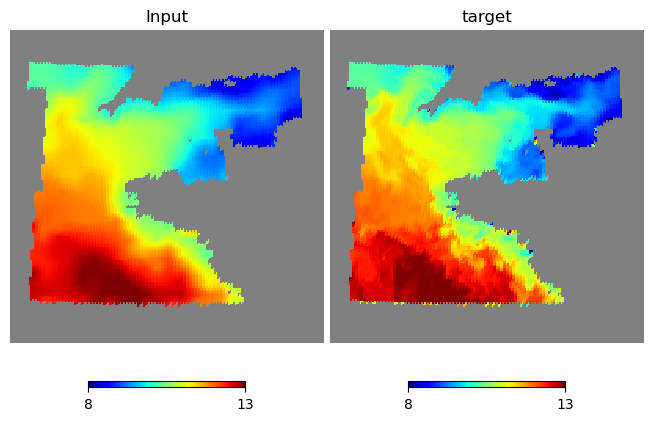

In [5]:
def plot_result(data,cell_ids,nside,hold=None,sub=None,title=None,
                unit=None,vmin=None,vmax=None,rot=[3.4,48.5],reso=2,norm=None):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=data
    if vmin is None:
        vmin=data.min()
    if vmax is None:
        vmax=data.max()
    hp.gnomview(im,cmap='jet',nest=True,rot=rot,
                reso=reso,hold=hold,sub=sub,notext=True,title=title,
                unit=unit,min=vmin,max=vmax,norm=norm)


plot_result(data,cell_ids,nside,hold=False,sub=(1,2,2),vmin=8,vmax=13,title='target')
plot_result(iref.cpu().numpy(),cell_ids,nside,hold=False,sub=(1,2,1),vmin=8,vmax=13,title='Input')

In [6]:
from foscat.healpix_unet_torch import HealpixUNet,fit

model = HealpixUNet(
    in_nside=nside,
    n_chan_in=1,
    chanlist=[8,16,32],
    cell_ids=cell_ids,           # finest-resolution nested ids
    KERNELSZ=3,
    task='regression',         # or 'regression' or 'segmentation'
    out_channels=1,              # e.g., #classes
    final_activation=None      # defaults: sigmoid if 1 class, else softmax; 'none' for regression
)

In [7]:
# refine with LBFGS
hist  = fit(model, iref[None,None,:],ref, n_epoch=100, view_epoch=10,optimizer='LBFGS')

# can also use ADAM optimiser
#hist = fit(model, iref[None,None,:],ref, n_epoch=2000, view_epoch=100,batch_size=1, lr=1e-3, optimizer='ADAM')

[epoch 10/100] loss=0.037793
[epoch 20/100] loss=0.013113
[epoch 30/100] loss=0.007386
[epoch 40/100] loss=0.004720
[epoch 50/100] loss=0.003494
[epoch 60/100] loss=0.002782
[epoch 70/100] loss=0.002310
[epoch 80/100] loss=0.001972
[epoch 90/100] loss=0.001711
[epoch 100/100] loss=0.001516


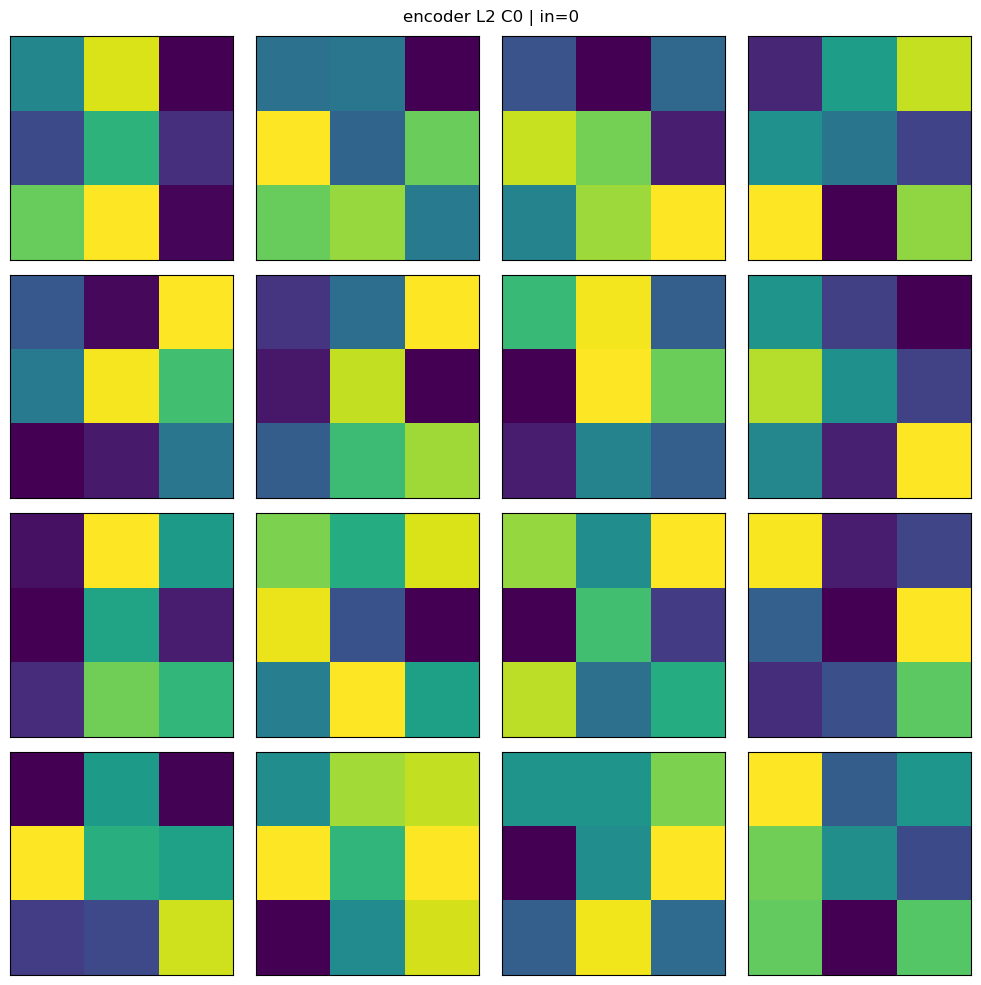

In [8]:
model.plot_kernels(layer=2)

Text(0, 0.5, 'Loss')

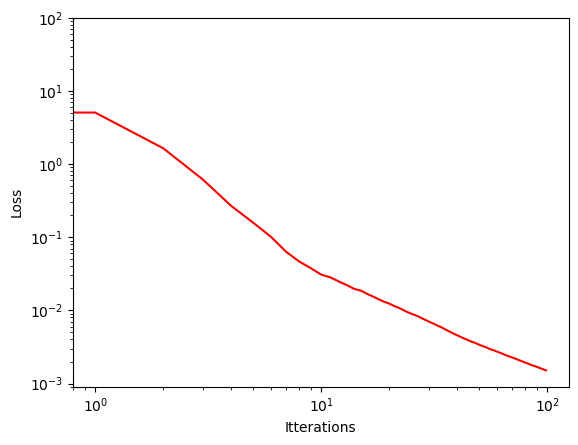

In [9]:
plt.plot(hist['loss'],color='r',label='LBFGS')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Itterations')
plt.ylabel('Loss')

In [10]:
y_pred = model.predict(iref[None,None,:]).cpu().numpy()[0,0]
y_pred.shape

(5722,)

Initia Loss 0.035709038376808167 Final Loss 0.0017272017430514097


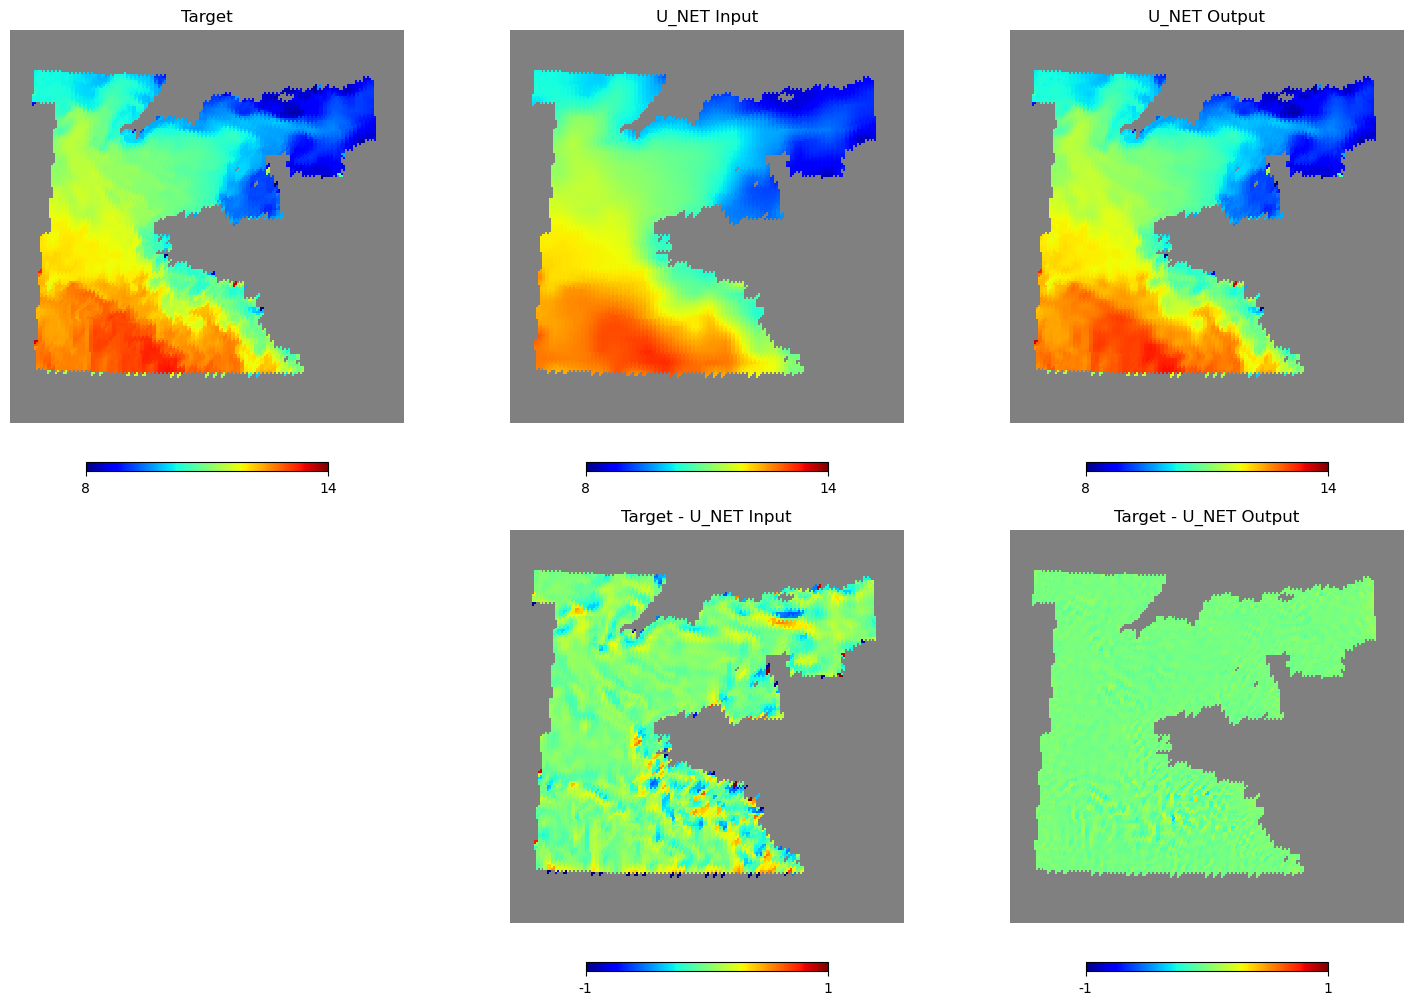

In [11]:
plt.figure(figsize=(15,10))
plot_result(ref.cpu().numpy(),cell_ids,nside,vmin=8,vmax=14,hold=False,sub=(2,3,1),title='Target')
plot_result(iref.cpu().numpy(),cell_ids,nside,vmin=8,vmax=14,hold=False,sub=(2,3,2),title='U_NET Input')
plot_result(y_pred,cell_ids,nside,vmin=8,vmax=14,hold=False,sub=(2,3,3),title='U_NET Output')
plot_result((ref-iref).cpu().numpy(),cell_ids,nside,vmin=-1,vmax=1,hold=False,sub=(2,3,5),title='Target - U_NET Input')
plot_result(ref.cpu().numpy()-y_pred,cell_ids,nside,vmin=-1,vmax=1,hold=False,sub=(2,3,6),title='Target - U_NET Output')
print(f'Initia Loss {np.mean(((ref-iref).cpu().numpy())**2)} Final Loss {np.mean(((ref.cpu().numpy()-y_pred))**2)}')